# Test models performences

2025-07-02 13:53:32.321439: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751453612.330716   15906 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751453612.333333   15906 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751453612.339975   15906 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1751453612.339990   15906 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1751453612.339991   15906 computation_placer.cc:177] computation placer alr

Shape of features: (497732, 7)


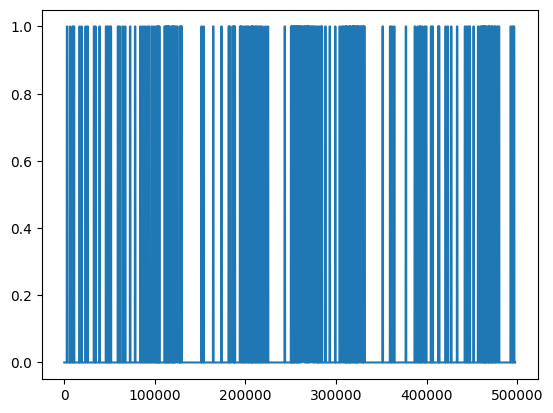

In [1]:
# import modules and load data
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, regularizers


import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Load input and output data
X = np.load("../data/processed/input.npy")
Y = np.load("../data/processed/output.npy")

# Modify the number of features
# Winners feature set
X = X[: , [1,2,3,4,10,11,12]]
nf = X.shape[1]
print(f"Shape of features: {X.shape}")

# TODO: Custom shuffle for RNN model
x_train_s, x_val_s, y_train_s, y_val_s = train_test_split(X, Y, test_size=0.1, shuffle=False)
x_train_s, x_test_s, y_train_s, y_test_s = train_test_split(x_train_s, y_train_s, test_size=0.11, shuffle=False)

# 15% test
# 15% validation
# 70% train

plt.plot(range(len(Y)), Y)
plt.show()

#### Model 1

In [ ]:
from sklearn.utils import class_weight
from model import create_sequences

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


# Number of frames fed into the LSTM layer at one time
sequence_length = 30 * 3

# The max number of neurons in the LSTM/RNN layer (min 16)
max_layer_neurons = 1024

# Reshape the data from (n, 14) to (n, sequence_length, 14)
x_train, y_train = create_sequences(x_train_s, y_train_s, sequence_length)
x_val, y_val = create_sequences(x_val_s, y_val_s, sequence_length)
x_test, y_test = create_sequences(x_test_s, y_test_s, sequence_length)

y_train = np.expand_dims(y_train, -1)
y_val = np.expand_dims(y_val, -1)
y_test = np.expand_dims(y_test, -1)


# Adapt the normlizer layer to the feature axis in the input data
normalizer = layers.Normalization(axis=-1)
normalizer.adapt(X)

# Define the model
model = tf.keras.Sequential([
    layers.Input((sequence_length,nf)),
    normalizer,
    # layers.SimpleRNN(max_layer_neurons, recurrent_dropout=0.1),  # or use LSTM
    layers.LSTM(max_layer_neurons, recurrent_dropout=0.1, kernel_regularizer=regularizers.l2(0.01), recurrent_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Dense(max_layer_neurons//2, activation='relu'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.2),
    layers.Dense(max_layer_neurons//4, activation='relu'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.2),
    layers.Dense(max_layer_neurons//8, activation='relu'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.1),
    layers.Dense(1, activation='sigmoid')  # Output a single scalar
])

METRICS = [
    #   tf.keras.metrics.BinaryCrossentropy(name='cross entropy'),  # same as model's loss
      tf.keras.metrics.MeanSquaredError(name='Brier score'),
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'),
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
      tf.keras.metrics.F1Score(name='f1', threshold=0.5)
]

# Add more metrices! (accuracy metric in not good for this classification ?)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=METRICS)

# Penalize the model more for misclassifying the minority class using class weight
# Calculate the class weights
# weights = class_weight.compute_class_weight(
#     class_weight='balanced',
#     classes=np.unique(Y.flatten()),
#     y=Y.flatten()
# )

# class_weights = dict(zip(np.unique(Y), np.round(weights, 3)))

class_weights = {0.0: 1.5, 1.0: 2.5}

print("Calculated Class Weights:", class_weights)


# 1. Configure the EarlyStopping callback
# This will monitor the validation loss and stop training if it doesn't improve.
early_stopping = EarlyStopping(
    monitor='val_f1',  # The metric to watch
    patience=3,          # How many epochs to wait for improvement before stopping
    min_delta=0.0001,     # Minimum change in the monitored quantity to qualify as an improvement
    mode='max',          # We want the 'val_loss' to decrease, so we use 'min' mode
    restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored quantity.
)


# Train model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=50, batch_size=400, class_weight=class_weights, callbacks=early_stopping)

## Test Performences

==== MODEL #1 ====
Probability Plot:


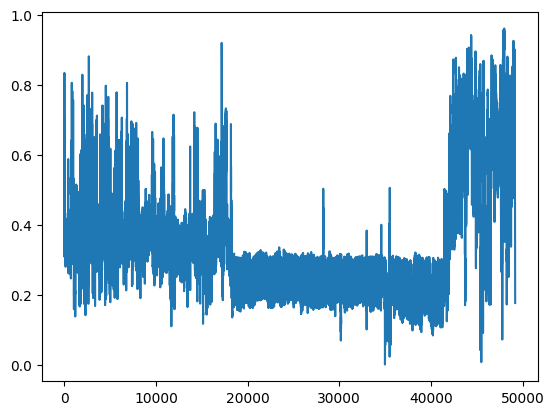

Predition/Test Plot:


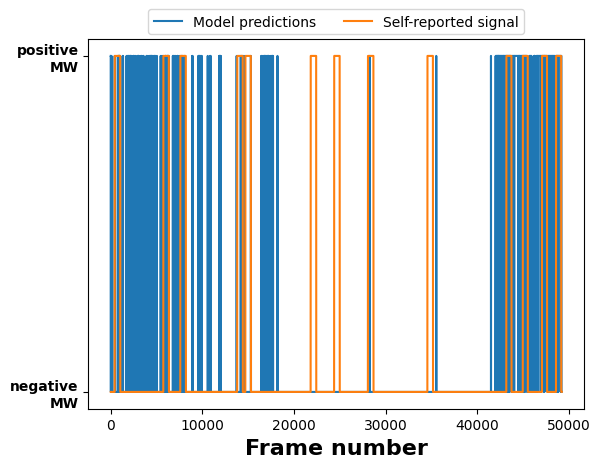

Classification Report:
               precision    recall  f1-score   support

         0.0       0.87      0.89      0.88     41536
         1.0       0.33      0.30      0.31      7651

    accuracy                           0.80     49187
   macro avg       0.60      0.59      0.60     49187
weighted avg       0.79      0.80      0.79     49187



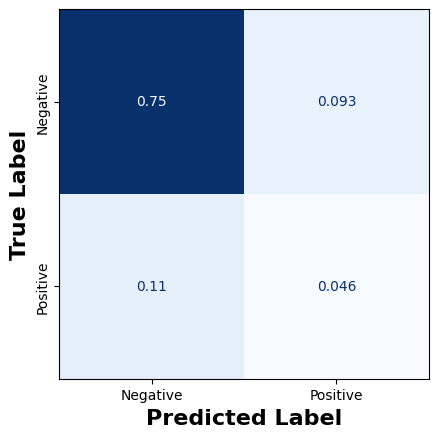

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import warnings

warnings.filterwarnings('ignore')

# Model 1
print("==== MODEL #1 ====")

# # Predict probabilities
y1_prob = model.predict(x_test)

# # Convert probabilities to binary predictions (> 50% for positive prediction)
y1_pred = (y1_prob >= 0.5).astype(int).squeeze() 

# Confusion Matrix
cm1 = confusion_matrix(y_test, y1_pred, normalize='all')
disp1 = ConfusionMatrixDisplay(cm1)

print("Probability Plot:")
plt.plot(range(len(y1_prob)), y1_prob)
plt.show()

print("Predition/Test Plot:")
plt.plot(range(len(y1_pred)) , y1_pred, y_test)
plt.xlabel('Frame number', fontsize=16, fontweight='bold')
plt.yticks([0,1], ['negative\nMW', 'positive\nMW'], fontsize=10, fontweight='bold') # Show ticks as MW states
plt.legend(['Model predictions', 'Self-reported signal'], loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.1))
plt.show()

# Classification Report
report1 = classification_report(y_test, y1_pred)

disp1.plot(colorbar=False, cmap='Blues')
tick_labels = ['Negative', 'Positive']
disp1.ax_.set_xticklabels(tick_labels)
disp1.ax_.set_yticklabels(tick_labels, rotation=90, va='center') # Rotate y-axis labels for readability

# Add titles and labels for clarity
plt.xlabel('Predicted Label', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=16, fontweight='bold')
print("Classification Report:\n", report1)


In [ ]:
from sklearn.metrics import classification_report, f1_score
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt

# --- SECTION 2: Analyze High-Pass Filtered Signal vs. Ground Truth ---

# Squeeze the probability array to 1D for filtering
y_prob_signal = y1_prob.squeeze()

# Filter design parameters
fs = 30  # Sampling frequency (assuming 30 fps video)
order = 5 # Filter order
high_cutoff = 0.5 # Hz

# High-pass filter to isolate rapid changes in probability
b_high, a_high = signal.butter(order, high_cutoff, btype='high', analog=False, fs=fs)
y_prob_highpass = signal.filtfilt(b_high, a_high, y_prob_signal)

# Plot the filtered signal against the ground truth for comparison
print("\n==== High-Pass Filtered Signal vs. Ground Truth Analysis ====\n")
plt.figure(figsize=(15, 6))
plt.plot(y_test, label='Ground Truth (y_test)', color='g', linewidth=2)
plt.plot(y_prob_highpass, label=f'High-pass Filtered (cutoff={high_cutoff}Hz)', color='r', alpha=0.7)
plt.title('High-Pass Filtered (Rapid Changes) Signal vs. Ground Truth')
plt.xlabel('Time (Frames)')
plt.ylabel('Signal Value')
plt.legend()
plt.grid(True)
plt.show()


# --- SECTION 2: Test High-Pass Filtered Signal Performance ---

print("\n==== High-Pass Filtered Signal Performance Analysis ====\n")
print("This section tests if the *rapid increase* in probability is a better predictor.")

# Test a range of small positive thresholds on the high-pass signal
hp_thresholds = np.arange(0.01, 2, 0.01)
hp_f1_scores = []

for thresh in hp_thresholds:
    y_pred_hp_temp = (y_prob_highpass >= thresh).astype(int)
    f1_hp = f1_score(y_test, y_pred_hp_temp, pos_label=1, zero_division=0)
    hp_f1_scores.append(f1_hp)

# Find the best threshold for the high-pass signal
if len(hp_f1_scores) > 0 and np.max(hp_f1_scores) > 0:
    best_hp_f1_index = np.argmax(hp_f1_scores)
    best_hp_threshold = hp_thresholds[best_hp_f1_index]
    best_hp_f1_hp = hp_f1_scores[best_hp_f1_index]

    print(f"Best F1-Score for High-Pass Signal: {best_hp_f1_hp:.4f}")
    print(f"Found at threshold: {best_hp_threshold:.2f}")

    # Generate and print the final classification report for the filtered signal
    print("\n==== Classification Report with High-Pass Filter Optimal Threshold ====\n")
    y_pred_best_hp = (y_prob_highpass >= best_hp_threshold).astype(int)
    report_best_hp = classification_report(y_test, y_pred_best_hp, zero_division=0)
    print(report_best_hp)
else:
    print("Could not find a suitable positive threshold for the high-pass filtered signal.")
    print("This may indicate that the rate-of-change is not a strong predictor on its own.")

In [ ]:
# Save the model and get info

model.save('last_model.keras')
model.summary()